**Goals**

Have a model that allows us to make system load balancing decisions based on demand
forecasting based on historical data. Load balancing means the planning of transporting
bicycles from one station to another.

**Outcome**

A model that indicates the optimal movement of bicycles to be made between stations,
and at what times or frequencies, to ensure that you perform the best system planning.

# Importing

In [1]:
import pandas as pd 
import numpy as np
import geopandas as gpd
import fiona
import os
import zipfile
from folium import Map, CircleMarker, Vega, Popup, Marker, PolyLine, Icon, Choropleth, LayerControl
from folium.plugins import MarkerCluster, HeatMap, BeautifyIcon
import shapely
import matplotlib
from ipywidgets import interact
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.tsa 
from datetime import datetime
import missingno as msno
import re

In [2]:
pd.set_option('display.max_rows', 100)

In [3]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
class Databases:
    def __init__(self, csv, anva, smm, metro):
        self.csv = csv
        self.anva = anva 
        self.smm = smm
        self.metro = metro

    def extract_csv(self):
        file = pd.read_csv(f'data/bike_loans/{self.csv}', sep=';')
        file['Fecha_Prestamo'] = pd.to_datetime(file['Fecha_Prestamo'])
        file['Fecha_Devolucion'] = pd.to_datetime(file['Fecha_Devolucion'])
        return file
        
    
    def extract_anva(self):
        bus_routes_AMVA = gpd.GeoDataFrame()
        for root, dirs, files in os.walk(f'data/bus_routes/medellin_bus_routes/{self.anva}'):
            for file in files:
                path = os.path.join(root, file)
                df = gpd.read_file(path, driver='KML')
                bus_routes_AMVA = gpd.GeoDataFrame(pd.concat([bus_routes_AMVA, df], ignore_index=True))
        return bus_routes_AMVA
    
    def extract_smm(self):
        smm_bus_routes = gpd.GeoDataFrame()
        for root, dirs, files in os.walk(f'data/bus_routes/medellin_bus_routes/{self.smm}'):
            for file in files:
                path = os.path.join(root, file)
                df = gpd.read_file(path, driver='KML')
                smm_bus_routes = gpd.GeoDataFrame(pd.concat([smm_bus_routes, df], ignore_index=True))
        return smm_bus_routes
    
    def extract_metro(self):
        metro_routes = gpd.GeoDataFrame()
        for root, dirs, files in os.walk(f'data/medellin_metro/{self.metro}'):
            for file in files:
                path = os.path.join(root, file)
                print(path)
                if path.endswith('.kmz'):
                    kmz = zipfile.ZipFile(path, 'r')
                    kml = kmz.open('doc.kml', 'r')
                    df = gpd.read_file(kml, driver='KML')
                    metro_routes = gpd.GeoDataFrame(pd.concat([metro_routes, df], ignore_index=True))
        return metro_routes


In [4]:
databases = Databases('bike_loans.csv','Kml Ruta AMVA','kml Ruta SMM','medellin_metro_stations')

In [5]:
bikes = databases.extract_csv()

In [6]:
bikes.dtypes

Id_Historico_Prestamo               int64
Id_Usuario                          int64
Id_Tag_Bicicleta                   object
Fecha_Prestamo             datetime64[ns]
Fecha_Devolucion           datetime64[ns]
Id_Aparcamiento_Origen              int64
Posicion_Origen                     int64
Id_Aparcamiento_Destino           float64
Posicion_Destino                  float64
Importe                           float64
DescripcionImporte                float64
operario                           object
Num_Bici_Hist                     float64
dtype: object

In [7]:
# metro = databases.extract_metro()

In [8]:
# smm = databases.extract_smm()

In [9]:
# anva = databases.extract_anva()

## Demand : Time Series

In [10]:
bikes['Fecha_Prestamo'] 

0          2017-06-21 14:22:11
1          2017-06-21 14:07:18
2          2017-06-21 14:25:11
3          2017-06-21 13:35:52
4          2017-06-21 14:17:56
                   ...        
14225350   2021-04-20 18:46:57
14225351   2021-04-20 18:28:09
14225352   2021-04-20 18:59:53
14225353   2021-04-20 18:45:42
14225354   2021-04-20 18:39:06
Name: Fecha_Prestamo, Length: 14225355, dtype: datetime64[ns]

In order to capture **trends and seasonality** properly, we decided to focus on **pre-pandemic** data. The first case diagnosed of Covid-19 in Colombia was on March 6th, 2020. Therefore, in order to avoid any bias in the data, we decided to focus on the data prior to 2020.

In [11]:
bikes_2019 = bikes[bikes['Fecha_Prestamo'].dt.year == 2019]
bikes_2019

,Id_Historico_Prestamo,Id_Usuario,Id_Tag_Bicicleta,Fecha_Prestamo,Fecha_Devolucion,Id_Aparcamiento_Origen,Posicion_Origen,Id_Aparcamiento_Destino,Posicion_Destino,Importe,DescripcionImporte,operario,Num_Bici_Hist
440864,10948569,20272,00FB73222B5E,2019-02-20 14:08:04,2019-02-20 14:26:08,9,1,43.0,1.0,0.0,NaN,anderson.rojas,1366.0
586995,12896369,135209,002772222B5E,2019-08-22 09:19:51,2019-08-22 09:20:31,44,15,44.0,15.0,0.0,NaN,NaN,976.0
726893,12896264,26536,00094A72BF5B,2019-08-22 09:11:22,2019-08-22 09:20:53,9,1,70.0,1.0,0.0,NaN,seguro.sorelly,2699.0
1028721,10948678,124512,00233C222B5E,2019-02-20 14:15:54,2019-02-20 14:26:28,89,2,56.0,1.0,0.0,NaN,NaN,638.0
2111125,10516625,40806,009F53222B5E,2019-01-02 12:57:01,2019-01-02 13:51:38,12,1,22.0,NaN,0.0,NaN,monitor.jannetv,558.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11767100,14454800,27944,0000F69A5A88,2019-12-31 13:58:55,2019-12-31 14:25:38,40,1,50.0,1.0,0.0,NaN,claudia.marin,541.0
11767101,14454778,108800,00029A222B5E,2019-12-31 13:52:48,2019-12-31 14:40:52,28,1,50.0,1.0,0.0,NaN,claudia.marin,715.0
11767102,14454793,98449,00001619CE0A,2019-12-31 13:55:47,2019-12-31 14:41:39,113,1,28.0,1.0,0.0,NaN,edison.graciano,3497.0
11767103,14454774,129665,000036885A88,2019-12-31 13:51:28,2019-12-31 16:27:12,39,15,41.0,15.0,0.0,NaN,NaN,534.0


In [12]:
bikes_2019[bikes_2019['Fecha_Devolucion'].dt.year == 2019]

,Id_Historico_Prestamo,Id_Usuario,Id_Tag_Bicicleta,Fecha_Prestamo,Fecha_Devolucion,Id_Aparcamiento_Origen,Posicion_Origen,Id_Aparcamiento_Destino,Posicion_Destino,Importe,DescripcionImporte,operario,Num_Bici_Hist
440864,10948569,20272,00FB73222B5E,2019-02-20 14:08:04,2019-02-20 14:26:08,9,1,43.0,1.0,0.0,NaN,anderson.rojas,1366.0
586995,12896369,135209,002772222B5E,2019-08-22 09:19:51,2019-08-22 09:20:31,44,15,44.0,15.0,0.0,NaN,NaN,976.0
726893,12896264,26536,00094A72BF5B,2019-08-22 09:11:22,2019-08-22 09:20:53,9,1,70.0,1.0,0.0,NaN,seguro.sorelly,2699.0
1028721,10948678,124512,00233C222B5E,2019-02-20 14:15:54,2019-02-20 14:26:28,89,2,56.0,1.0,0.0,NaN,NaN,638.0
2111125,10516625,40806,009F53222B5E,2019-01-02 12:57:01,2019-01-02 13:51:38,12,1,22.0,NaN,0.0,NaN,monitor.jannetv,558.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11767100,14454800,27944,0000F69A5A88,2019-12-31 13:58:55,2019-12-31 14:25:38,40,1,50.0,1.0,0.0,NaN,claudia.marin,541.0
11767101,14454778,108800,00029A222B5E,2019-12-31 13:52:48,2019-12-31 14:40:52,28,1,50.0,1.0,0.0,NaN,claudia.marin,715.0
11767102,14454793,98449,00001619CE0A,2019-12-31 13:55:47,2019-12-31 14:41:39,113,1,28.0,1.0,0.0,NaN,edison.graciano,3497.0
11767103,14454774,129665,000036885A88,2019-12-31 13:51:28,2019-12-31 16:27:12,39,15,41.0,15.0,0.0,NaN,NaN,534.0


In [13]:
# Id_Historico_Prestamo - represents ID of the load
# Id_Usuario - id of the users
# Id_Tag_Bicicleta - Id of the bycicle
# Fecha_Prestamo - loan start date/time
# Fecha_Devolucion - load end date/time
# Id_Aparcamiento_Origen - Id of Parking station
# Posicion_Origen - position of the bike in the bike station 
# Importe - not sure 
# DescripcionImporte - same here not sure
# operario - whether the station was automatic or ran manually by someone
# Num_Bici_Hist - not entirely sure but could be number of times the bike was used 

In [14]:
bikes_2019.shape

(3798179, 13)

In [15]:
# finding the hours where demand is greatest
bikes_2019['Fecha_Prestamo'].dt.hour.value_counts()

17    398804
16    304701
7     301402
18    287356
12    269854
13    263868
15    254296
14    249533
11    246460
6     217452
9     216158
10    205345
8     204297
19    170820
20    113428
5      91421
21      1693
22       939
4        346
23         6
Name: Fecha_Prestamo, dtype: int64

<AxesSubplot:title={'center':'Distribution of Demand per Hour'}, xlabel='Fecha_Prestamo'>

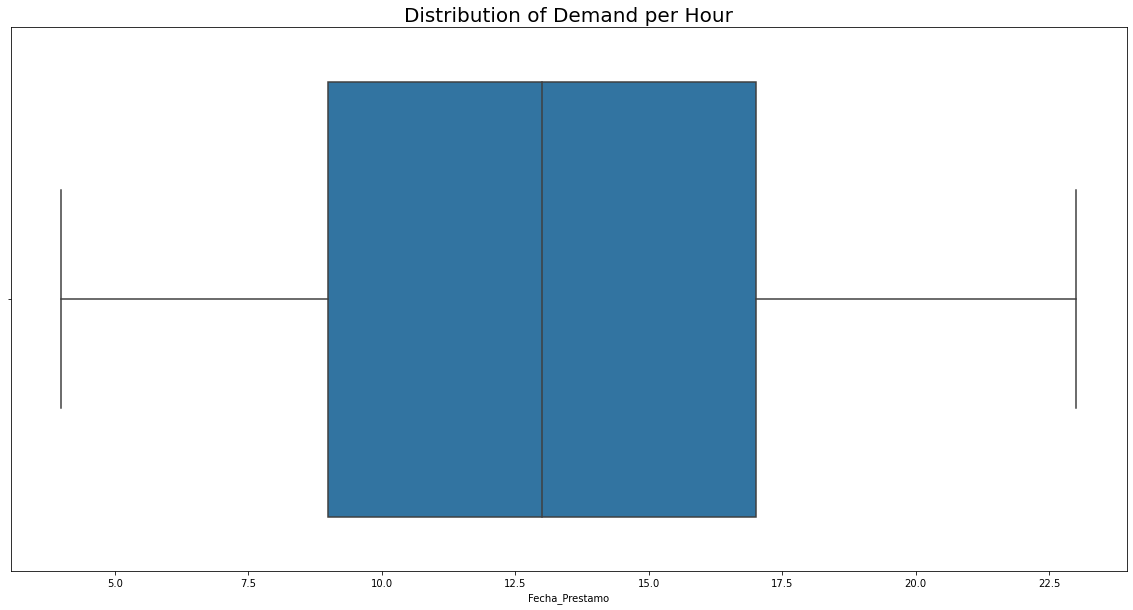

In [16]:
# exploring the times of day where demand is strongest
plt.figure(figsize=(20,10))
plt.title('Distribution of Demand per Hour', size=20)
sns.boxplot(x=bikes_2019['Fecha_Prestamo'].dt.hour)

<AxesSubplot:title={'center':'Demand Per Hour'}, xlabel='Fecha_Prestamo', ylabel='Count'>

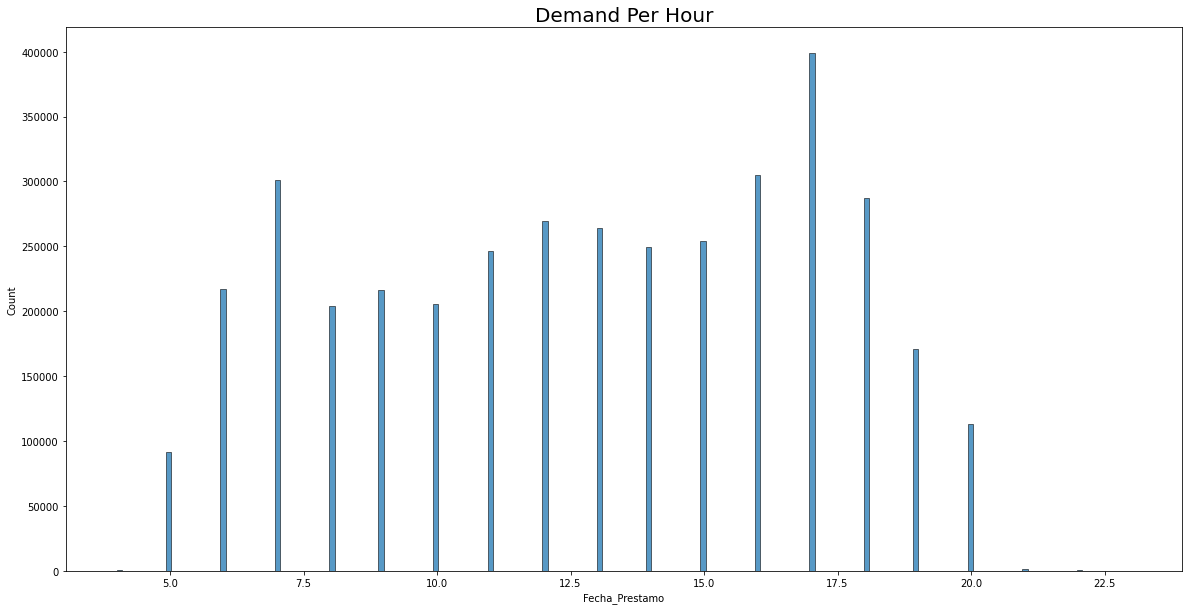

In [17]:
plt.figure(figsize=(20,10))
plt.title('Demand Per Hour', size=20)
sns.histplot(data=bikes_2019, x = bikes_2019['Fecha_Prestamo'].dt.hour)

## Feature Creation

In [18]:
bikes_2019['Id_Aparcamiento_Origen'].isna().sum(), bikes_2019['Id_Aparcamiento_Destino'].isna().sum()

(0, 1009)

In [19]:
bikes_2019['Id_Aparcamiento_Destino'] = bikes_2019['Id_Aparcamiento_Destino'].fillna(-1)

<ipython-input-19-d8da1c92065b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes_2019['Id_Aparcamiento_Destino'] = bikes_2019['Id_Aparcamiento_Destino'].fillna(-1)


In [20]:
bikes_2019.dtypes

Id_Historico_Prestamo               int64
Id_Usuario                          int64
Id_Tag_Bicicleta                   object
Fecha_Prestamo             datetime64[ns]
Fecha_Devolucion           datetime64[ns]
Id_Aparcamiento_Origen              int64
Posicion_Origen                     int64
Id_Aparcamiento_Destino           float64
Posicion_Destino                  float64
Importe                           float64
DescripcionImporte                float64
operario                           object
Num_Bici_Hist                     float64
dtype: object

In [21]:
bikes_2019['Id_Aparcamiento_Destino'] = bikes_2019['Id_Aparcamiento_Destino'].astype(int)

<ipython-input-21-09a7dd4f56ba>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes_2019['Id_Aparcamiento_Destino'] = bikes_2019['Id_Aparcamiento_Destino'].astype(int)


In [22]:
bikes_2019

,Id_Historico_Prestamo,Id_Usuario,Id_Tag_Bicicleta,Fecha_Prestamo,Fecha_Devolucion,Id_Aparcamiento_Origen,Posicion_Origen,Id_Aparcamiento_Destino,Posicion_Destino,Importe,DescripcionImporte,operario,Num_Bici_Hist
440864,10948569,20272,00FB73222B5E,2019-02-20 14:08:04,2019-02-20 14:26:08,9,1,43,1.0,0.0,NaN,anderson.rojas,1366.0
586995,12896369,135209,002772222B5E,2019-08-22 09:19:51,2019-08-22 09:20:31,44,15,44,15.0,0.0,NaN,NaN,976.0
726893,12896264,26536,00094A72BF5B,2019-08-22 09:11:22,2019-08-22 09:20:53,9,1,70,1.0,0.0,NaN,seguro.sorelly,2699.0
1028721,10948678,124512,00233C222B5E,2019-02-20 14:15:54,2019-02-20 14:26:28,89,2,56,1.0,0.0,NaN,NaN,638.0
2111125,10516625,40806,009F53222B5E,2019-01-02 12:57:01,2019-01-02 13:51:38,12,1,22,NaN,0.0,NaN,monitor.jannetv,558.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11767100,14454800,27944,0000F69A5A88,2019-12-31 13:58:55,2019-12-31 14:25:38,40,1,50,1.0,0.0,NaN,claudia.marin,541.0
11767101,14454778,108800,00029A222B5E,2019-12-31 13:52:48,2019-12-31 14:40:52,28,1,50,1.0,0.0,NaN,claudia.marin,715.0
11767102,14454793,98449,00001619CE0A,2019-12-31 13:55:47,2019-12-31 14:41:39,113,1,28,1.0,0.0,NaN,edison.graciano,3497.0
11767103,14454774,129665,000036885A88,2019-12-31 13:51:28,2019-12-31 16:27:12,39,15,41,15.0,0.0,NaN,NaN,534.0


In [23]:
def supply_demand(x):
        if x >= 0:
            return 1
        elif x < 0:
            return 0

In [24]:
bikes_2019['Id_Aparcamiento_Destino']

440864       43
586995       44
726893       70
1028721      56
2111125      22
           ... 
11767100     50
11767101     50
11767102     28
11767103     41
11767179    118
Name: Id_Aparcamiento_Destino, Length: 3798179, dtype: int64

In [25]:
bikes_2019['demand'] = bikes_2019['Id_Aparcamiento_Origen'].apply(supply_demand)

<ipython-input-25-98d5cd64df22>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes_2019['demand'] = bikes_2019['Id_Aparcamiento_Origen'].apply(supply_demand)


In [26]:
bikes_2019['supply'] = bikes_2019['Id_Aparcamiento_Destino'].apply(supply_demand)

<ipython-input-26-8b06c82cee7b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes_2019['supply'] = bikes_2019['Id_Aparcamiento_Destino'].apply(supply_demand)


In [27]:
bikes_2019['supply'].isin([0]).sum()

1009

In [28]:
bikes_2019['supply']

440864      1
586995      1
726893      1
1028721     1
2111125     1
           ..
11767100    1
11767101    1
11767102    1
11767103    1
11767179    1
Name: supply, Length: 3798179, dtype: int64

In [29]:
bikes_2019.head()

,Id_Historico_Prestamo,Id_Usuario,Id_Tag_Bicicleta,Fecha_Prestamo,Fecha_Devolucion,Id_Aparcamiento_Origen,Posicion_Origen,Id_Aparcamiento_Destino,Posicion_Destino,Importe,DescripcionImporte,operario,Num_Bici_Hist,demand,supply
440864,10948569,20272,00FB73222B5E,2019-02-20 14:08:04,2019-02-20 14:26:08,9,1,43,1.0,0.0,NaN,anderson.rojas,1366.0,1,1
586995,12896369,135209,002772222B5E,2019-08-22 09:19:51,2019-08-22 09:20:31,44,15,44,15.0,0.0,NaN,NaN,976.0,1,1
726893,12896264,26536,00094A72BF5B,2019-08-22 09:11:22,2019-08-22 09:20:53,9,1,70,1.0,0.0,NaN,seguro.sorelly,2699.0,1,1
1028721,10948678,124512,00233C222B5E,2019-02-20 14:15:54,2019-02-20 14:26:28,89,2,56,1.0,0.0,NaN,NaN,638.0,1,1
2111125,10516625,40806,009F53222B5E,2019-01-02 12:57:01,2019-01-02 13:51:38,12,1,22,NaN,0.0,NaN,monitor.jannetv,558.0,1,1


In [30]:
bikes_2019['Fecha_Prestamo'].dt.hour

440864      14
586995       9
726893       9
1028721     14
2111125     12
            ..
11767100    13
11767101    13
11767102    13
11767103    13
11767179    13
Name: Fecha_Prestamo, Length: 3798179, dtype: int64

In [31]:
bikes_2019['loan_date_hour'] = bikes_2019['Fecha_Prestamo'].dt.date.astype('string') + " " + bikes_2019['Fecha_Prestamo'].dt.hour.astype('string')

<ipython-input-31-92205b9216d9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes_2019['loan_date_hour'] = bikes_2019['Fecha_Prestamo'].dt.date.astype('string') + " " + bikes_2019['Fecha_Prestamo'].dt.hour.astype('string')


In [32]:
bikes_2019['deposit_date_hour'] = bikes_2019['Fecha_Devolucion'].dt.date.astype('string') + " " + bikes_2019['Fecha_Devolucion'].dt.hour.astype('string')

<ipython-input-32-8adb7e42f686>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes_2019['deposit_date_hour'] = bikes_2019['Fecha_Devolucion'].dt.date.astype('string') + " " + bikes_2019['Fecha_Devolucion'].dt.hour.astype('string')


In [33]:
bikes_2019['deposit_date_hour']

440864      2019-02-20 14
586995       2019-08-22 9
726893       2019-08-22 9
1028721     2019-02-20 14
2111125     2019-01-02 13
                ...      
11767100    2019-12-31 14
11767101    2019-12-31 14
11767102    2019-12-31 14
11767103    2019-12-31 16
11767179    2019-12-31 15
Name: deposit_date_hour, Length: 3798179, dtype: string

In [34]:
bikes_2019['loan_date_hour']

440864      2019-02-20 14
586995       2019-08-22 9
726893       2019-08-22 9
1028721     2019-02-20 14
2111125     2019-01-02 12
                ...      
11767100    2019-12-31 13
11767101    2019-12-31 13
11767102    2019-12-31 13
11767103    2019-12-31 13
11767179    2019-12-31 13
Name: loan_date_hour, Length: 3798179, dtype: string

In [35]:
bikes_2019.head()

,Id_Historico_Prestamo,Id_Usuario,Id_Tag_Bicicleta,Fecha_Prestamo,Fecha_Devolucion,Id_Aparcamiento_Origen,Posicion_Origen,Id_Aparcamiento_Destino,Posicion_Destino,Importe,DescripcionImporte,operario,Num_Bici_Hist,demand,supply,loan_date_hour,deposit_date_hour
440864,10948569,20272,00FB73222B5E,2019-02-20 14:08:04,2019-02-20 14:26:08,9,1,43,1.0,0.0,NaN,anderson.rojas,1366.0,1,1,2019-02-20 14,2019-02-20 14
586995,12896369,135209,002772222B5E,2019-08-22 09:19:51,2019-08-22 09:20:31,44,15,44,15.0,0.0,NaN,NaN,976.0,1,1,2019-08-22 9,2019-08-22 9
726893,12896264,26536,00094A72BF5B,2019-08-22 09:11:22,2019-08-22 09:20:53,9,1,70,1.0,0.0,NaN,seguro.sorelly,2699.0,1,1,2019-08-22 9,2019-08-22 9
1028721,10948678,124512,00233C222B5E,2019-02-20 14:15:54,2019-02-20 14:26:28,89,2,56,1.0,0.0,NaN,NaN,638.0,1,1,2019-02-20 14,2019-02-20 14
2111125,10516625,40806,009F53222B5E,2019-01-02 12:57:01,2019-01-02 13:51:38,12,1,22,NaN,0.0,NaN,monitor.jannetv,558.0,1,1,2019-01-02 12,2019-01-02 13


In [36]:
# total demand for each stations = 100
demand_per_station = bikes_2019[['demand']].groupby(bikes_2019['Id_Aparcamiento_Origen']).sum()
demand_per_station.sort_values(by = 'demand', ascending=False)

,demand
Id_Aparcamiento_Origen,
8,204545
7,165887
89,136500
12,127869
3,123145
2,121632
66,115671
67,108413
1,100919


In [37]:
bikes_2019.dtypes

Id_Historico_Prestamo               int64
Id_Usuario                          int64
Id_Tag_Bicicleta                   object
Fecha_Prestamo             datetime64[ns]
Fecha_Devolucion           datetime64[ns]
Id_Aparcamiento_Origen              int64
Posicion_Origen                     int64
Id_Aparcamiento_Destino             int64
Posicion_Destino                  float64
Importe                           float64
DescripcionImporte                float64
operario                           object
Num_Bici_Hist                     float64
demand                              int64
supply                              int64
loan_date_hour                     string
deposit_date_hour                  string
dtype: object

In [38]:
bikes_2019['demand_per_station_per_time'] = bikes_2019['Id_Aparcamiento_Origen'].astype('string') + " " + bikes_2019['loan_date_hour']

<ipython-input-38-81722faab387>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes_2019['demand_per_station_per_time'] = bikes_2019['Id_Aparcamiento_Origen'].astype('string') + " " + bikes_2019['loan_date_hour']


In [39]:
bikes_2019['supply_per_station_per_time'] = bikes_2019['Id_Aparcamiento_Destino'].astype('string') + " " + bikes_2019['deposit_date_hour']

<ipython-input-39-018f8d7faed9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes_2019['supply_per_station_per_time'] = bikes_2019['Id_Aparcamiento_Destino'].astype('string') + " " + bikes_2019['deposit_date_hour']


In [40]:
# demand_per_station_per_time is a new column that includes information about the station position, date and hour of loans
# this is to facilitate the join/merge for the new time-series DF
bikes_2019

,Id_Historico_Prestamo,Id_Usuario,Id_Tag_Bicicleta,Fecha_Prestamo,Fecha_Devolucion,Id_Aparcamiento_Origen,Posicion_Origen,Id_Aparcamiento_Destino,Posicion_Destino,Importe,DescripcionImporte,operario,Num_Bici_Hist,demand,supply,loan_date_hour,deposit_date_hour,demand_per_station_per_time,supply_per_station_per_time
440864,10948569,20272,00FB73222B5E,2019-02-20 14:08:04,2019-02-20 14:26:08,9,1,43,1.0,0.0,NaN,anderson.rojas,1366.0,1,1,2019-02-20 14,2019-02-20 14,9 2019-02-20 14,43 2019-02-20 14
586995,12896369,135209,002772222B5E,2019-08-22 09:19:51,2019-08-22 09:20:31,44,15,44,15.0,0.0,NaN,NaN,976.0,1,1,2019-08-22 9,2019-08-22 9,44 2019-08-22 9,44 2019-08-22 9
726893,12896264,26536,00094A72BF5B,2019-08-22 09:11:22,2019-08-22 09:20:53,9,1,70,1.0,0.0,NaN,seguro.sorelly,2699.0,1,1,2019-08-22 9,2019-08-22 9,9 2019-08-22 9,70 2019-08-22 9
1028721,10948678,124512,00233C222B5E,2019-02-20 14:15:54,2019-02-20 14:26:28,89,2,56,1.0,0.0,NaN,NaN,638.0,1,1,2019-02-20 14,2019-02-20 14,89 2019-02-20 14,56 2019-02-20 14
2111125,10516625,40806,009F53222B5E,2019-01-02 12:57:01,2019-01-02 13:51:38,12,1,22,NaN,0.0,NaN,monitor.jannetv,558.0,1,1,2019-01-02 12,2019-01-02 13,12 2019-01-02 12,22 2019-01-02 13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11767100,14454800,27944,0000F69A5A88,2019-12-31 13:58:55,2019-12-31 14:25:38,40,1,50,1.0,0.0,NaN,claudia.marin,541.0,1,1,2019-12-31 13,2019-12-31 14,40 2019-12-31 13,50 2019-12-31 14
11767101,14454778,108800,00029A222B5E,2019-12-31 13:52:48,2019-12-31 14:40:52,28,1,50,1.0,0.0,NaN,claudia.marin,715.0,1,1,2019-12-31 13,2019-12-31 14,28 2019-12-31 13,50 2019-12-31 14
11767102,14454793,98449,00001619CE0A,2019-12-31 13:55:47,2019-12-31 14:41:39,113,1,28,1.0,0.0,NaN,edison.graciano,3497.0,1,1,2019-12-31 13,2019-12-31 14,113 2019-12-31 13,28 2019-12-31 14
11767103,14454774,129665,000036885A88,2019-12-31 13:51:28,2019-12-31 16:27:12,39,15,41,15.0,0.0,NaN,NaN,534.0,1,1,2019-12-31 13,2019-12-31 16,39 2019-12-31 13,41 2019-12-31 16


In [41]:
demand_per_station_per_time = bikes_2019[['demand']].groupby(bikes_2019['demand_per_station_per_time']).sum()

In [42]:
demand_per_station_per_time.reset_index(inplace=True)

In [43]:
demand_per_station_per_time

,demand_per_station_per_time,demand
0,1 2019-01-02 10,5
1,1 2019-01-02 11,8
2,1 2019-01-02 12,17
3,1 2019-01-02 13,7
4,1 2019-01-02 14,12
...,...,...
280484,99 2019-12-31 11,8
280485,99 2019-12-31 12,13
280486,99 2019-12-31 13,6
280487,99 2019-12-31 8,1


In [44]:
supply_per_station_per_time = bikes_2019[['supply']].groupby(bikes_2019['supply_per_station_per_time']).sum()

In [45]:
supply_per_station_per_time.reset_index(inplace=True)

In [46]:
supply_per_station_per_time

,supply_per_station_per_time,supply
0,-1 2019-01-02 14,0
1,-1 2019-01-02 17,0
2,-1 2019-01-02 22,0
3,-1 2019-01-03 13,0
4,-1 2019-01-03 14,0
...,...,...
299249,99 2019-12-31 5,1
299250,99 2019-12-31 6,1
299251,99 2019-12-31 7,1
299252,99 2019-12-31 8,5


In [47]:
demand_per_station_per_time[['station','date','time']] = demand_per_station_per_time.demand_per_station_per_time.str.split(" ",expand=True)

In [48]:
supply_per_station_per_time[['station','date','time']] = supply_per_station_per_time.supply_per_station_per_time.str.split(" ",expand=True)

In [49]:
demand_per_station_per_time

,demand_per_station_per_time,demand,station,date,time
0,1 2019-01-02 10,5,1,2019-01-02,10
1,1 2019-01-02 11,8,1,2019-01-02,11
2,1 2019-01-02 12,17,1,2019-01-02,12
3,1 2019-01-02 13,7,1,2019-01-02,13
4,1 2019-01-02 14,12,1,2019-01-02,14
...,...,...,...,...,...
280484,99 2019-12-31 11,8,99,2019-12-31,11
280485,99 2019-12-31 12,13,99,2019-12-31,12
280486,99 2019-12-31 13,6,99,2019-12-31,13
280487,99 2019-12-31 8,1,99,2019-12-31,8


In [50]:
supply_per_station_per_time

,supply_per_station_per_time,supply,station,date,time
0,-1 2019-01-02 14,0,-1,2019-01-02,14
1,-1 2019-01-02 17,0,-1,2019-01-02,17
2,-1 2019-01-02 22,0,-1,2019-01-02,22
3,-1 2019-01-03 13,0,-1,2019-01-03,13
4,-1 2019-01-03 14,0,-1,2019-01-03,14
...,...,...,...,...,...
299249,99 2019-12-31 5,1,99,2019-12-31,5
299250,99 2019-12-31 6,1,99,2019-12-31,6
299251,99 2019-12-31 7,1,99,2019-12-31,7
299252,99 2019-12-31 8,5,99,2019-12-31,8


In [51]:
# as we can see the greatest demand is for station 1 between 17-18
demand_per_station_per_time.sort_values(by = 'demand', ascending =False).head(100)

,demand_per_station_per_time,demand,station,date,time
240722,7 2019-10-08 7,139,7,2019-10-08,7
244911,70 2019-09-27 14,120,70,2019-09-27,14
240467,7 2019-09-19 7,117,7,2019-09-19,7
231702,66 2019-08-29 17,116,66,2019-08-29,17
240740,7 2019-10-09 7,115,7,2019-10-09,7
240580,7 2019-09-27 7,115,7,2019-09-27,7
239027,7 2019-05-31 7,113,7,2019-05-31,7
239107,7 2019-06-07 7,112,7,2019-06-07,7
248720,8 2019-08-12 17,112,8,2019-08-12,17
231992,66 2019-09-19 17,112,66,2019-09-19,17


In [52]:
supply_per_station_per_time.sort_values(by = 'supply', ascending =False).head(100)

,supply_per_station_per_time,supply,station,date,time
266178,8 2019-10-29 17,169,8,2019-10-29,17
265213,8 2019-08-22 18,167,8,2019-08-22,18
266179,8 2019-10-29 18,163,8,2019-10-29,18
265313,8 2019-08-29 17,158,8,2019-08-29,17
261169,70 2019-10-08 8,153,70,2019-10-08,8
265073,8 2019-08-12 18,152,8,2019-08-12,18
265720,8 2019-09-26 17,150,8,2019-09-26,17
266279,8 2019-11-06 17,150,8,2019-11-06,17
259736,70 2019-06-11 8,149,70,2019-06-11,8
266263,8 2019-11-05 18,148,8,2019-11-05,18


In [79]:
df1 = demand_per_station_per_time.copy()
df1

,demand_per_station_per_time,demand,station,date,time
0,1 2019-01-02 10,5,1,2019-01-02,10
1,1 2019-01-02 11,8,1,2019-01-02,11
2,1 2019-01-02 12,17,1,2019-01-02,12
3,1 2019-01-02 13,7,1,2019-01-02,13
4,1 2019-01-02 14,12,1,2019-01-02,14
...,...,...,...,...,...
280484,99 2019-12-31 11,8,99,2019-12-31,11
280485,99 2019-12-31 12,13,99,2019-12-31,12
280486,99 2019-12-31 13,6,99,2019-12-31,13
280487,99 2019-12-31 8,1,99,2019-12-31,8


In [80]:
df2 = supply_per_station_per_time.copy()
df2

,supply_per_station_per_time,supply,station,date,time
0,-1 2019-01-02 14,0,-1,2019-01-02,14
1,-1 2019-01-02 17,0,-1,2019-01-02,17
2,-1 2019-01-02 22,0,-1,2019-01-02,22
3,-1 2019-01-03 13,0,-1,2019-01-03,13
4,-1 2019-01-03 14,0,-1,2019-01-03,14
...,...,...,...,...,...
299249,99 2019-12-31 5,1,99,2019-12-31,5
299250,99 2019-12-31 6,1,99,2019-12-31,6
299251,99 2019-12-31 7,1,99,2019-12-31,7
299252,99 2019-12-31 8,5,99,2019-12-31,8


<AxesSubplot:>

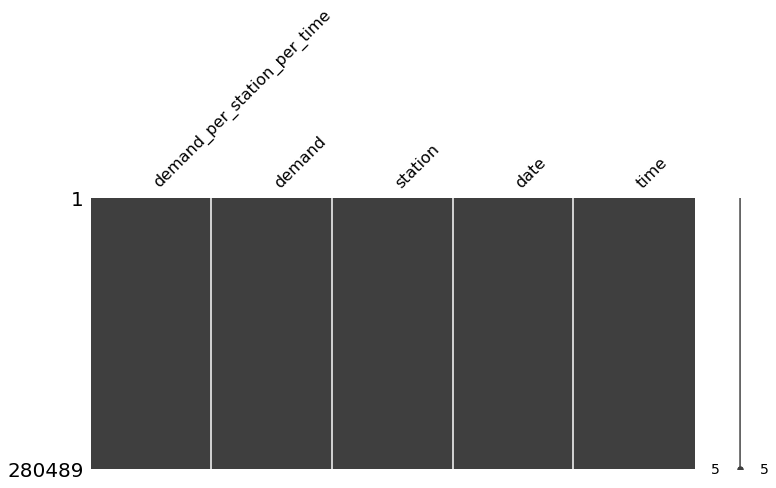

In [81]:
msno.matrix(df1,figsize=(12,5))

<AxesSubplot:>

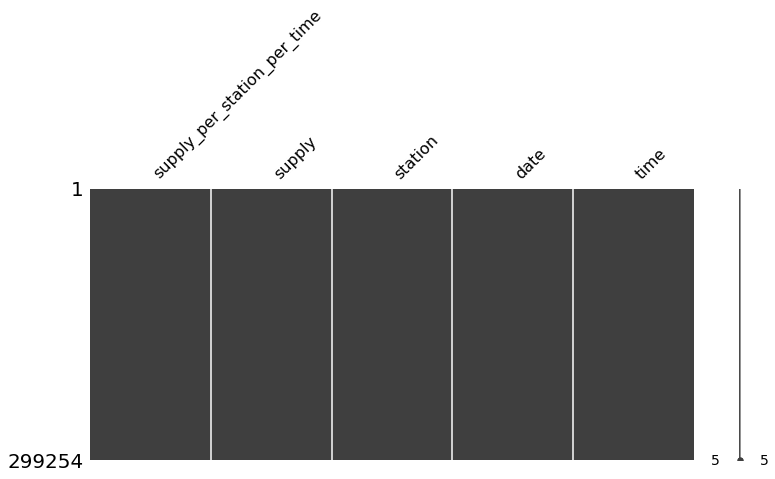

In [82]:
msno.matrix(df2,figsize=(12,5))

Since it will be difficult to built a time-series with all the stations, maybe we can build a function where you impute
which station you would like to forecast the demand for, and it tells you. 

What I was also thinking is to have the same df as above, but add new columns with like number of times it reached this destination IDs. 
So for example, have another 100 columns (each representing a station of **destination demand**. 

The last row has 199 demand, but how do we know where they are goin ?

Other interesting columns we can add are **seasons, holidays, working, days, temp, windy speed**

https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile

In [83]:
df1.dtypes

demand_per_station_per_time    object
demand                          int64
station                        object
date                           object
time                           object
dtype: object

In [84]:
df2.dtypes

supply_per_station_per_time    object
supply                          int64
station                        object
date                           object
time                           object
dtype: object

In [85]:
def string_to_int(df, cols):
    df[cols] =  df[cols].astype(int)
    return df

In [86]:
df1 = string_to_int(df1, ['station','time'])
df2 = string_to_int(df2, ['station','time'])

In [87]:
df1

,demand_per_station_per_time,demand,station,date,time
0,1 2019-01-02 10,5,1,2019-01-02,10
1,1 2019-01-02 11,8,1,2019-01-02,11
2,1 2019-01-02 12,17,1,2019-01-02,12
3,1 2019-01-02 13,7,1,2019-01-02,13
4,1 2019-01-02 14,12,1,2019-01-02,14
...,...,...,...,...,...
280484,99 2019-12-31 11,8,99,2019-12-31,11
280485,99 2019-12-31 12,13,99,2019-12-31,12
280486,99 2019-12-31 13,6,99,2019-12-31,13
280487,99 2019-12-31 8,1,99,2019-12-31,8


In [88]:
df2

,supply_per_station_per_time,supply,station,date,time
0,-1 2019-01-02 14,0,-1,2019-01-02,14
1,-1 2019-01-02 17,0,-1,2019-01-02,17
2,-1 2019-01-02 22,0,-1,2019-01-02,22
3,-1 2019-01-03 13,0,-1,2019-01-03,13
4,-1 2019-01-03 14,0,-1,2019-01-03,14
...,...,...,...,...,...
299249,99 2019-12-31 5,1,99,2019-12-31,5
299250,99 2019-12-31 6,1,99,2019-12-31,6
299251,99 2019-12-31 7,1,99,2019-12-31,7
299252,99 2019-12-31 8,5,99,2019-12-31,8


In [89]:
def strip_left(df, index):
    df.iloc[:,index]=  df.iloc[:,index].str.strip()
    return df

In [90]:
df1 = strip_left(df1, 0)
df2 = strip_left(df2, 0)

In [91]:
pattern = re.compile(r'2019.*') 

In [92]:
def year_month_day_hour(x):
    try:
        return pattern.search(x).group()
    except AttributeError:
        return 'aight'

In [93]:
df1['year_month_day_hour'] = df1['demand_per_station_per_time'].apply(year_month_day_hour)

In [94]:
df2.isna().sum()

supply_per_station_per_time    0
supply                         0
station                        0
date                           0
time                           0
dtype: int64

In [95]:
df2['year_month_day_hour'] = df2['supply_per_station_per_time'].apply(year_month_day_hour)

In [96]:
df2['year_month_day_hour'].isna().sum()

0

In [97]:
df1['year_month_day_hour'].isna().sum()

0

In [98]:
# for some reason stations were kept in the data after filtering for 2019
df2[df2['year_month_day_hour'] == 'aight']

,supply_per_station_per_time,supply,station,date,time,year_month_day_hour
531,1 2018-12-04 10,1,1,2018-12-04,10,aight
5393,10 2018-12-04 10,1,10,2018-12-04,10,aight
22613,12 2018-04-10 6,3,12,2018-04-10,6,aight
27569,13 2018-05-30 1,3,13,2018-05-30,1,aight
36966,2 2017-10-24 1,1,2,2017-10-24,1,aight
36967,2 2018-04-10 6,4,2,2018-04-10,6,aight
36968,2 2018-05-30 1,1,2,2018-05-30,1,aight
61283,24 2018-12-04 10,1,24,2018-12-04,10,aight
79835,32 2013-10-04 0,5,32,2013-10-04,0,aight
88530,34 2017-10-24 2,1,34,2017-10-24,2,aight


### SLICING 

In [99]:
def drop_col(df):
    return df.iloc[:,1:]

In [100]:
df1 = drop_col(df1)
df2 = drop_col(df2)

In [101]:
def convert_to_date(x):
    return datetime.strptime(x, '%Y-%m-%d %H')

In [102]:
df1 = strip_left(df1, -1)
df2 = strip_left(df2, -1)

In [103]:
df1['year_month_day_hour'].apply(convert_to_date)
df2['year_month_day_hour'].apply(convert_to_date)

ValueError: time data 'aight' does not match format '%Y-%m-%d %H'

### OTHER LATER STUFF

In [ ]:
# aggregated demand per hour between 2014-2019 
ad_per_hour = df1.groupby('time').sum()
ad_per_hour.sort_index(ascending=True)

In [ ]:
plt.figure(figsize=(20,10))
sns.barplot(data=ad_per_hour, x=ad_per_hour.index, y='demand')

In [ ]:
df1['year_month_day_hour'] = df1['year_month_day_hour'].apply(convert_to_date)

In [ ]:
# switching to int because it was previously string - avoids ' ' when boolean indexing
def convert_to_int
    df1['station'] = df1['station'].astype(int)

In [ ]:
df1

In [ ]:
df1[df1['station']== 1].head(10)

**Basically, we would like to predict the future demand of bikes per bike station based on the above DF. The problem is that we have missing rows/dates in our dataset. Our question is whether we can built time-series with missing dates or whether we should impute numbers** 

**The program was launched in 2014, so obviously there might be gaps as the program probably took some time to grow**

In [ ]:
df1[df1['station']== 1].tail(10)

In [ ]:
df1

**Our goal would be to create a program/function that allows us to predict the demand per station on an hourly basis. And let's say on a 1-2 week horizon** 